# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
#     cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
#     X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    from keras.datasets import cifar10

    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    X_train, X_test = X_train.astype('float64'), X_test.astype('float64')
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Using TensorFlow backend.


Train data shape:  (49000, 3073)
Train labels shape:  (49000, 1)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000, 1)
Test data shape:  (1000, 3073)
Test labels shape:  (1000, 1)
dev data shape:  (500, 3073)
dev labels shape:  (500, 1)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.336686
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*


In [4]:
grad_check_sparse??

Object `grad_check_sparse` not found.


In [5]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

print()
# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 4.463943 analytic: 4.463943, relative error: 1.162538e-08
numerical: -1.230580 analytic: -1.230580, relative error: 3.200191e-09
numerical: -3.091661 analytic: -3.091661, relative error: 1.642361e-08
numerical: 1.228146 analytic: 1.228146, relative error: 1.119207e-08
numerical: -1.796507 analytic: -1.796507, relative error: 1.066857e-08
numerical: 1.481838 analytic: 1.481838, relative error: 6.230413e-09
numerical: -2.922477 analytic: -2.922477, relative error: 1.680444e-08
numerical: 0.732149 analytic: 0.732149, relative error: 6.420104e-08
numerical: 3.290055 analytic: 3.290055, relative error: 2.210961e-08
numerical: 0.646620 analytic: 0.646620, relative error: 2.196256e-08

numerical: -0.186052 analytic: -0.186052, relative error: 8.193695e-08
numerical: -0.405112 analytic: -0.405112, relative error: 1.638228e-07
numerical: -2.361808 analytic: -2.361807, relative error: 1.054668e-08
numerical: -0.663787 analytic: -0.663787, relative error: 1.223983e-08
numerical: -0.709

# &&&&&&&& test zone &&&&&&&&

In [6]:
X = np.array([[1,2,3,1],[2,3,4,1],[2,3,4,1]]).astype(np.float64)
y = np.array([[0],[2],[0]])
w = np.array([[2,5,3],[4,6,3],[3,5,7],[4,5,8]]).astype(np.float64)

num_classes = 3
num_train = 3
y = y.reshape(num_train,)

In [7]:
loss, grad = softmax_loss_naive(w, X, y, 0)
print('True Loss:' + str(loss))
print('\nGrad: ')
print(grad)

True Loss:12.8557059782

Grad: 
[[-0.99999992  1.26404322 -0.2640433 ]
 [-1.66666652  1.9408884  -0.27422188]
 [-2.33333311  2.61773357 -0.28440046]
 [-0.66666659  0.67684517 -0.01017858]]


In [8]:
np.array([1,2,3,1])*0.731058415142

array([ 0.73105842,  1.46211683,  2.19317525,  0.73105842])

In [9]:
scores = np.dot(X,w)
print('Scores: ')
print(scores)

score_exp = np.exp(scores)
print('\nExp_Scores: ')
print(score_exp)

exp_sum = np.sum(score_exp, axis = 1).reshape(num_train,1)
print('\nexp_sum: ')
print(exp_sum)

Scores: 
[[ 23.  37.  38.]
 [ 32.  53.  51.]
 [ 32.  53.  51.]]

Exp_Scores: 
[[  9.74480345e+09   1.17191424e+16   3.18559318e+16]
 [  7.89629602e+13   1.04137594e+23   1.40934908e+22]
 [  7.89629602e+13   1.04137594e+23   1.40934908e+22]]

exp_sum: 
[[  4.35750839e+16]
 [  1.18231085e+23]
 [  1.18231085e+23]]


In [10]:
dw = np.dot(X.T,score_exp/exp_sum)-np.dot(X.T,correct_index)

NameError: name 'correct_index' is not defined

In [ ]:
np.dot(X.T,score_exp/exp_sum)

In [ ]:
dw/3

In [ ]:
print('\nGrad: ')
print(grad)

In [ ]:
correct_index = np.eye(num_classes)[y].astype('int')
correct = np.exp(scores[np.where(correct_index)].reshape(num_train,1))
print(correct_index)
correct

In [ ]:
loss = np.mean(-np.log(correct/exp_sum))
loss

In [ ]:
score_exp/exp_sum

In [ ]:
dW = np.dot(X.T,scores/exp_sum)
dW

In [ ]:
dW = dW/num_train
dW

## &&&&&&&&&&& end of test zone &&&&&&&&&&&

In [ ]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
t0 = toc - tic
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))
t1 = toc - tic

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

print(str(t0/t1) + ' times faster')

In [11]:
from cs231n.classifiers import Softmax

In [17]:
cla = Softmax()

loss = cla.train(X_train, y_train,learning_rate=1e-7,reg=2.5e4,num_iters=100)

In [21]:
cla.eval(X_train,y_train)

0.15555102040816327

In [28]:
permutations?

In [35]:
product?

In [36]:
from itertools import product

product(range(3),range(2))

In [62]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
from itertools import product

results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-6, 3e-6, 5e-6, 7e-6]
regularization_strengths = [8e3, 1e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################


for lr,reg in product(learning_rates,regularization_strengths):

    softmax = Softmax()
    Loss = softmax.train(X_train, y_train,learning_rate = lr, reg = reg, num_iters = 100)
    
    train_accu = softmax.eval(X_train,y_train)
    val_accu = softmax.eval(X_val,y_val)
    if val_accu > best_val:
        best_val = val_accu
        best_softmax = softmax
        
    results[(lr,reg)] = [train_accu,val_accu]


################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-06 reg 8.000000e+03 train accuracy: 0.278245 val accuracy: 0.275000
lr 1.000000e-06 reg 1.000000e+04 train accuracy: 0.280796 val accuracy: 0.284000
lr 1.000000e-06 reg 5.000000e+04 train accuracy: 0.309837 val accuracy: 0.321000
lr 3.000000e-06 reg 8.000000e+03 train accuracy: 0.336714 val accuracy: 0.339000
lr 3.000000e-06 reg 1.000000e+04 train accuracy: 0.344469 val accuracy: 0.360000
lr 3.000000e-06 reg 5.000000e+04 train accuracy: 0.253551 val accuracy: 0.260000
lr 5.000000e-06 reg 8.000000e+03 train accuracy: 0.303633 val accuracy: 0.301000
lr 5.000000e-06 reg 1.000000e+04 train accuracy: 0.312061 val accuracy: 0.326000
lr 5.000000e-06 reg 5.000000e+04 train accuracy: 0.214755 val accuracy: 0.213000
lr 7.000000e-06 reg 8.000000e+03 train accuracy: 0.204816 val accuracy: 0.209000
lr 7.000000e-06 reg 1.000000e+04 train accuracy: 0.284898 val accuracy: 0.304000
lr 7.000000e-06 reg 5.000000e+04 train accuracy: 0.190245 val accuracy: 0.179000
best validation accuracy ach

In [63]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.352000


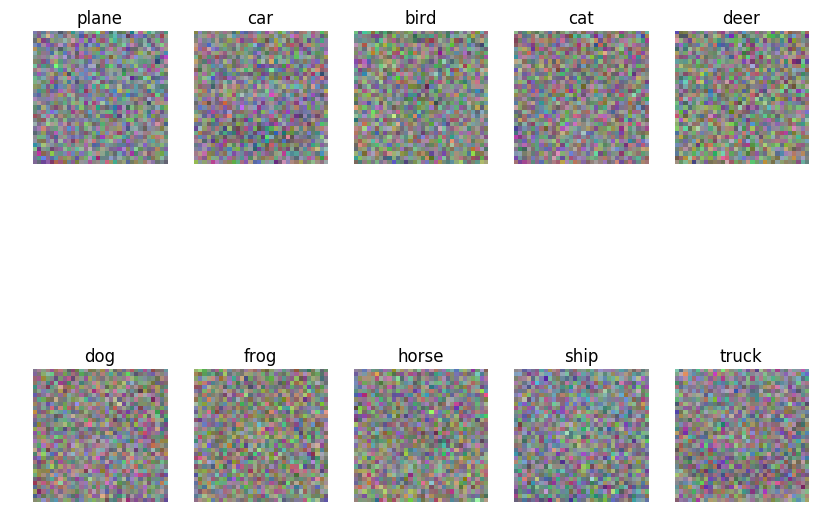

In [53]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])